# Overview
<br>  

### References
- [jqassistant](https://jqassistant.org)
- [Neo4j Python Driver](https://neo4j.com/docs/api/python-driver/current)

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plot
from neo4j import GraphDatabase

In [2]:
# Please set the environment variable "NEO4J_INITIAL_PASSWORD" in your shell 
# before starting jupyter notebook to provide the password for the user "neo4j". 
# It is not recommended to hardcode the password into jupyter notebook for security reasons.

driver = GraphDatabase.driver(uri="bolt://localhost:7687", auth=("neo4j", os.environ.get("NEO4J_INITIAL_PASSWORD")))
driver.verify_connectivity()

In [3]:
def get_cypher_query_from_file(filename):
    with open(filename) as file:
        return ' '.join(file.readlines())

In [4]:
def query_cypher_to_data_frame(filename):
    records, summary, keys = driver.execute_query(get_cypher_query_from_file(filename))
    return pd.DataFrame([r.values() for r in records], columns=keys)

In [5]:
#The following cell uses the build-in %html "magic" to override the CSS style for tables to a much smaller size.
#This is especially needed for PDF export of tables with multiple columns.

In [6]:
%%html
<style>
/* CSS style for smaller dataframe tables. */
.dataframe th {
    font-size: 8px;
}
.dataframe td {
    font-size: 8px;
}
</style>

In [7]:
# Main Colormap
main_color_map = 'nipy_spectral'

## Overview

### Table 1 - Size

In [8]:
overview_size = query_cypher_to_data_frame("../cypher/Overview/Overview_size.cypher")
overview_size

,nodeCount,relationshipCount,artifactCount,packageCount,typeCount,methodCount,memberCount
0,71156,206658,6,97,1654,6935,8414


## Artifacts

### Table 2a - Largest 30 types per artifact

This table shows the largest (number of types) artifacts and their kind of types (Class, Interface, Enum, Annotation).
The whole table can be found in the CSV report `Number_of_types_per_artifact`.

In [9]:
types_per_artifact = query_cypher_to_data_frame("../cypher/Overview/Number_of_types_per_artifact.cypher")
types_per_artifact.head(30)

,artifactName,numberOfArtifactTypes,languageElement,numberOfTypes
0,axon-messaging-4.9.2,786,Class,587
1,axon-messaging-4.9.2,786,Interface,154
2,axon-messaging-4.9.2,786,Enum,19
3,axon-messaging-4.9.2,786,Annotation,26
4,axon-modelling-4.9.2,156,Interface,28
5,axon-modelling-4.9.2,156,Class,113
6,axon-modelling-4.9.2,156,Enum,3
7,axon-modelling-4.9.2,156,Annotation,12
8,axon-eventsourcing-4.9.2,133,Class,98
9,axon-eventsourcing-4.9.2,133,Interface,32


### Table 2b - Largest 30 types per artifact grouped

This table shows the largest (number of types) artifacts each in one row, their kind of types in columns and the count of them as values.

The source data for this aggregated table can be found in the CSV report `Number_of_types_per_artifact`.

In [10]:
# Pivot the DataFrame to 
# - group by the first column (artifactName) as new index
# - convert the values in the second column (typeLabel) 
# - into columns with the value of the third column (numberOfTypes).
types_per_artifact_grouped = types_per_artifact.pivot(index='artifactName', columns='languageElement', values='numberOfTypes')

# Fill missing values with zero
types_per_artifact_grouped.fillna(0, inplace=True)

# Calculate the sum of values for each row
types_per_artifact_grouped['Total'] = types_per_artifact_grouped.sum(axis=1)

# Sort the DataFrame by the sum of values
types_per_artifact_grouped.sort_values(by='Total', ascending=False, inplace=True)

# Remove the 'Total' column
types_per_artifact_grouped.drop('Total', axis=1, inplace=True)

# Sort the order of the columns by their sum
column_sum = types_per_artifact_grouped.sum()
types_per_artifact_grouped = types_per_artifact_grouped[column_sum.sort_values(ascending=False).index[:]]

# Convert to integer
types_per_artifact_grouped.astype(int).head(30)

languageElement,Class,Interface,Annotation,Enum
artifactName,,,,
axon-messaging-4.9.2,587,154,26,19
axon-modelling-4.9.2,113,28,12,3
axon-eventsourcing-4.9.2,98,32,1,2
axon-test-4.9.2,71,16,0,0
axon-configuration-4.9.2,23,15,1,1
axon-disruptor-4.9.2,22,0,0,0


### Table 2b Chart 1 - 30 largest artifacts and their types stacked

<Figure size 640x480 with 0 Axes>

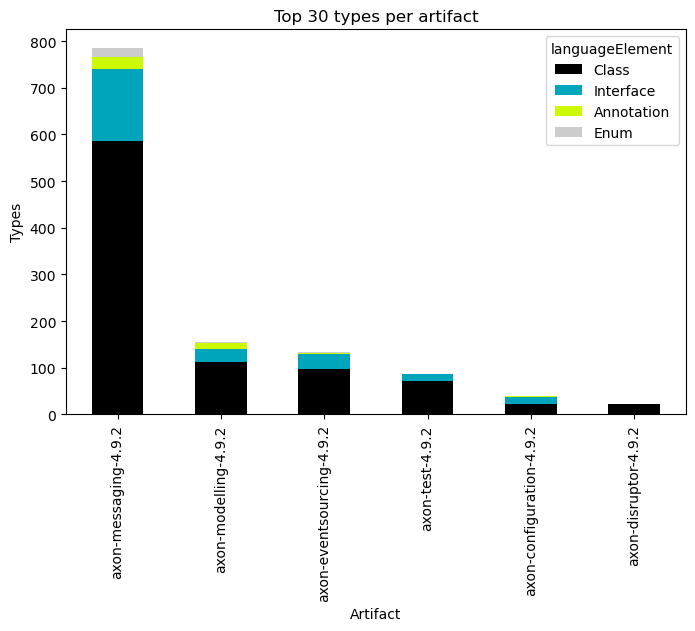

In [11]:
plot.figure();
types_per_artifact_grouped.head(30).plot(
    kind='bar', 
    title='Top 30 types per artifact',
    xlabel='Artifact',
    ylabel='Types',
    stacked=True, 
    cmap=main_color_map,
    figsize=(8, 5)
)
plot.show()

### Table 2c - Largest 30 types per artifact (grouped and normalized in %)

In [12]:
# Divide every value by the sum of the row to get horizontal normalized values.
# This makes it easier to compare the "language element" usage without taking the size of the artifact into account
types_per_artifact_grouped_normalized = types_per_artifact_grouped.div(types_per_artifact_grouped.sum(axis=1), axis=0).multiply(100)
types_per_artifact_grouped_normalized.head(30)

languageElement,Class,Interface,Annotation,Enum
artifactName,,,,
axon-messaging-4.9.2,74.681934,19.592875,3.307888,2.417303
axon-modelling-4.9.2,72.435897,17.948718,7.692308,1.923077
axon-eventsourcing-4.9.2,73.684211,24.060150,0.751880,1.503759
axon-test-4.9.2,81.609195,18.390805,0.000000,0.000000
axon-configuration-4.9.2,57.500000,37.500000,2.500000,2.500000
axon-disruptor-4.9.2,100.000000,0.000000,0.000000,0.000000


### Table 2c Chart 1 - Top 30 artifacts with the highest relative amount of classes in %

<Figure size 640x480 with 0 Axes>

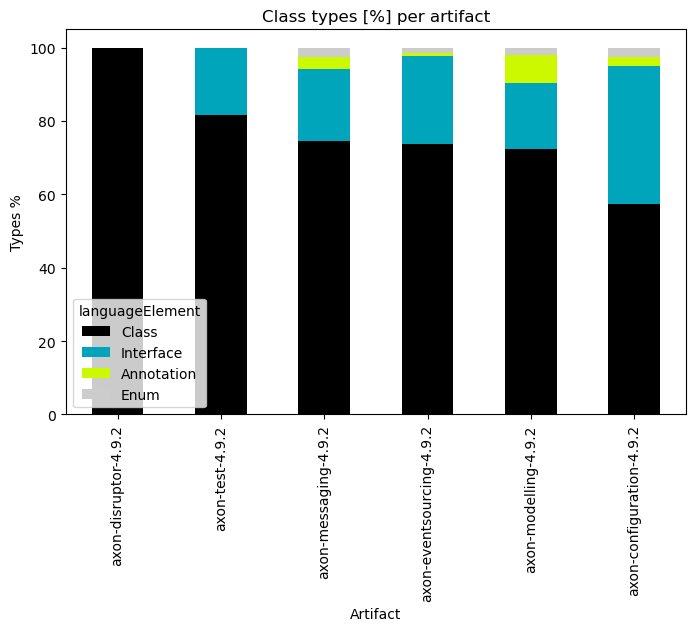

In [13]:
types_per_artifact_sorted_by_classes=types_per_artifact_grouped_normalized.sort_values(by='Class', ascending=False)

plot.figure();
types_per_artifact_sorted_by_classes.head(30).plot(kind='bar', stacked=True, cmap=main_color_map, figsize=(8, 5))
plot.xlabel('Artifact')
plot.ylabel('Types %')
plot.title('Class types [%] per artifact')
plot.show()

### Table 2c Chart 2 - Top 30 artifacts with the highest relative amount of interfaces in %

<Figure size 640x480 with 0 Axes>

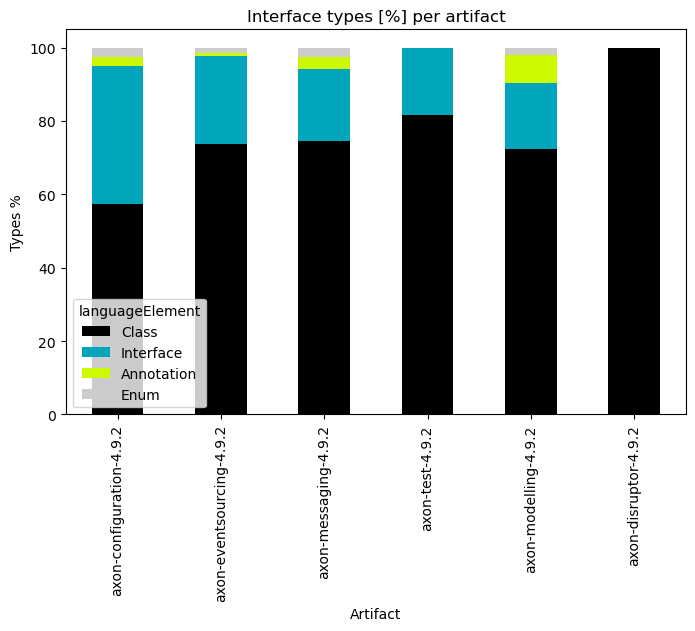

In [14]:
types_per_artifact_sorted_by_interfaces=types_per_artifact_grouped_normalized.sort_values(by='Interface', ascending=False)

plot.figure();
types_per_artifact_sorted_by_interfaces.head(30).plot(kind='bar', stacked=True, cmap=main_color_map, figsize=(8, 5))
plot.xlabel('Artifact')
plot.ylabel('Types %')
plot.title('Interface types [%] per artifact')
plot.show()

### Table 2c Chart 3 - Top 30 artifacts with the highest relative amount of enums in %

<Figure size 640x480 with 0 Axes>

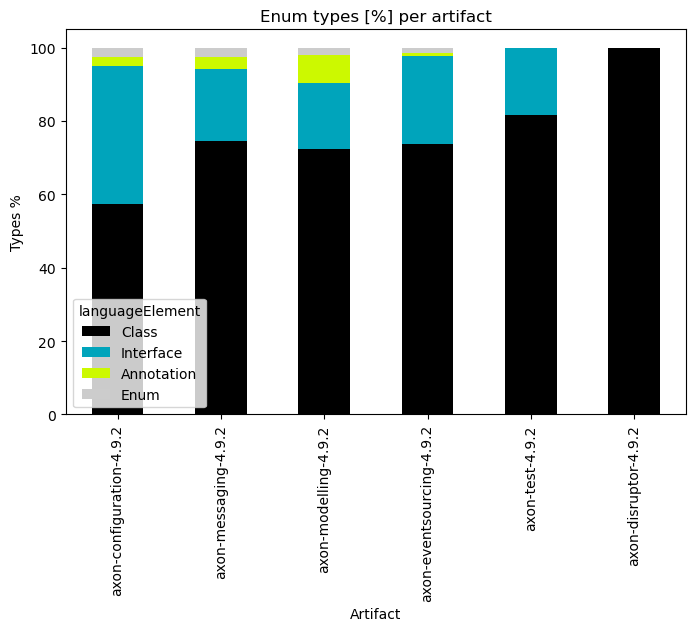

In [15]:
types_per_artifact_sorted_by_enums=types_per_artifact_grouped_normalized.sort_values(by='Enum', ascending=False)

plot.figure();
types_per_artifact_sorted_by_enums.head(30).plot(kind='bar', stacked=True, cmap=main_color_map, figsize=(8, 5))
plot.xlabel('Artifact')
plot.ylabel('Types %')
plot.title('Enum types [%] per artifact')
plot.show()

### Table 2c Chart 4 - Top 30 artifacts with the highest relative amount of annotations in %

<Figure size 640x480 with 0 Axes>

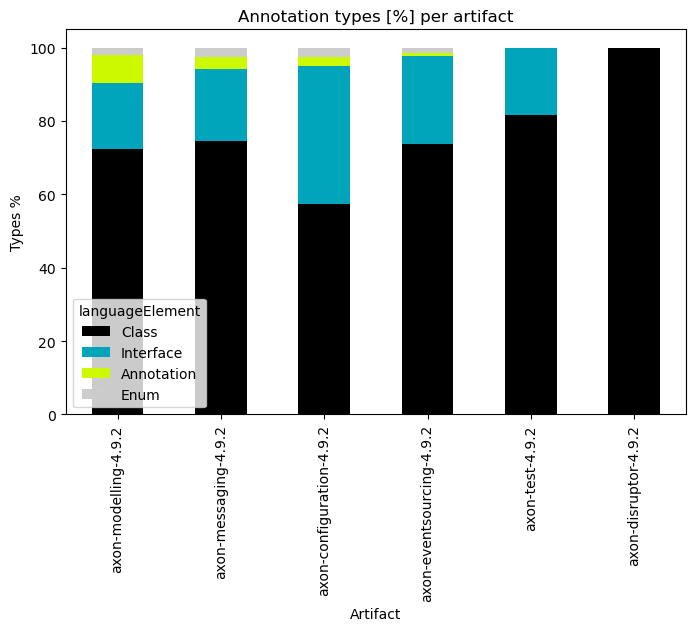

In [16]:
types_per_artifact_sorted_by_annotations=types_per_artifact_grouped_normalized.sort_values(by='Annotation', ascending=False)

plot.figure();
types_per_artifact_sorted_by_annotations.head(30).plot(kind='bar', stacked=True, cmap=main_color_map, figsize=(8, 5))
plot.xlabel('Artifact')
plot.ylabel('Types %')
plot.title('Annotation types [%] per artifact')
plot.show()

### Table 3 - Top 30 artifacts with the highest package count

The whole table can be found in the CSV report `Number_of_packages_per_artifact`.

In [17]:
packages_per_artifact = query_cypher_to_data_frame("../cypher/Overview/Number_of_packages_per_artifact.cypher")

# Sort the DataFrame by the sum of values
types_per_artifact_sorted = packages_per_artifact.sort_values(by='numberOfPackages', ascending=False).reset_index(drop=True)

# Set the name of the index to artifactName
#types_per_artifact_sorted.set_index('artifactName', inplace=True)

types_per_artifact_sorted.head(30)

,artifactName,numberOfPackages
0,axon-messaging-4.9.2,64
1,axon-modelling-4.9.2,10
2,axon-eventsourcing-4.9.2,9
3,axon-test-4.9.2,8
4,axon-disruptor-4.9.2,1
5,axon-configuration-4.9.2,1


### Table 3 Chart 1 - Number of packages per artifact

The following chat shows artifacts with the largest package count in percentage. Artifacts with less than 0.7% package count are grouped into "others" to focus on the most significant artifacts regarding their package count.

In [18]:
def group_to_others_below_threshold(data_frame : pd.DataFrame, value_column : str, name_column: str, threshold: float) -> pd.DataFrame:    
    """Adds a new percentage column for the value column and 
    groups all values below the given threshold to "others" in the name column.

    Parameters:
    - data_frame (pd.DataFrame): Input pandas DataFrame
    - value_column (str): Name of the column that contains the numeric value
    - name_column (str): Name of the column that contains the group name that will be replaced by "others" for small values
    - threshold (float): Threshold in % that is used to group values below it into the "others" group

    Returns:
    int:Returning value

    """
    result_data_frame = data_frame.copy();

    percent_column_name = value_column + 'Percent';

    # Add column with the name given in "percent_column_name" with the percentage of the value column.
    result_data_frame[percent_column_name] = result_data_frame[value_column] / result_data_frame[value_column].sum() * 100.0;

    # Change the external package name to "others" if it is called less than the specified threshold
    result_data_frame.loc[result_data_frame[percent_column_name] < threshold, name_column] = 'others';

    # Group external package name (foremost the new "others" entries) and sum their percentage
    result_data_frame = result_data_frame.groupby(name_column)[percent_column_name].sum();

    # Sort by values descending
    return result_data_frame.sort_values(ascending=False);

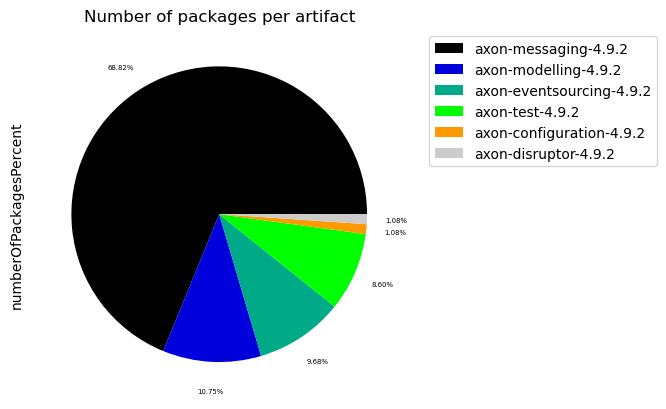

In [19]:
types_per_artifact_sorted_significant=group_to_others_below_threshold(
    data_frame=types_per_artifact_sorted,
    value_column='numberOfPackages',
    name_column='artifactName',
    threshold= 0.7
);

plot.figure();
types_per_artifact_sorted_significant.plot(
    y='numberOfPackages', 
    kind='pie', 
    title='Number of packages per artifact', 
    legend=True,
    labeldistance=None,
    autopct='%1.2f%%',
    textprops={'fontsize': 5},
    pctdistance=1.2,
    cmap=main_color_map
)
plot.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plot.show()